In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, precision_recall_curve, auc, roc_curve, classification_report, accuracy_score
from tabulate import tabulate
import joblib


In [2]:
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED']=str(RANDOM_SEED)

random.seed(RANDOM_SEED)

np.random.seed(RANDOM_SEED)

In [3]:
mitbih_train = pd.read_csv('mitbih_train.csv', header=None)
mitbih_test = pd.read_csv('mitbih_test.csv', header=None)



# Variáveis para treino
X_train = mitbih_train.iloc[:, :-1].values
y_train = mitbih_train.iloc[:, -1].values

# Variáveis para teste e validação (50% teste - 50% validação)
X_test, X_val, y_test, y_val = train_test_split(mitbih_test.iloc[:, :-1].values,
                                                mitbih_test.iloc[:, -1].values,
                                                test_size=0.5,
                                                random_state=RANDOM_SEED)

#X_test = mitbih_test.iloc[:, :-1].values
#y_test = mitbih_test.iloc[:, -1].values

In [4]:
def print_avg_and_mean(dict):
    # Ponderado
    weighted_avg_precision = dict['weighted avg']['precision']
    weighted_avg_recall = dict['weighted avg']['recall']
    weighted_avg_f1_score = dict['weighted avg']['f1-score']
    weighted_avg_support = dict['weighted avg']['support']

    # Aritmético
    mean_precision = np.mean([dict[label]["precision"] for label in dict.keys() if label != "accuracy"])
    mean_recall = np.mean([dict[label]["recall"] for label in dict.keys() if label != "accuracy"]
    )
    mean_f1_score = np.mean([dict[label]["f1-score"] for label in dict.keys() if label != "accuracy"])
    mean_support = np.mean([dict[label]["support"] for label in dict.keys() if label != "accuracy"])

    print(f'Média Ponderada - Precisão: {weighted_avg_precision}')
    print(f'Média Ponderada - Recall: {weighted_avg_recall}')
    print(f'Média Ponderada - F1-Score: {weighted_avg_f1_score}')
    print(f'Média Ponderada - Support: {weighted_avg_support}')
    print('--------------------------------------------------')
    print(f'Média Aritmética - Precisão: {mean_precision}')
    print(f'Média Aritmética - Recall: {mean_recall}')
    print(f'Média Aritmética - F1-Score: {mean_f1_score}')
    print(f'Média Aritmética - Support: {mean_support}')

Treino: 87554
Teste:  10946
Total: 98500


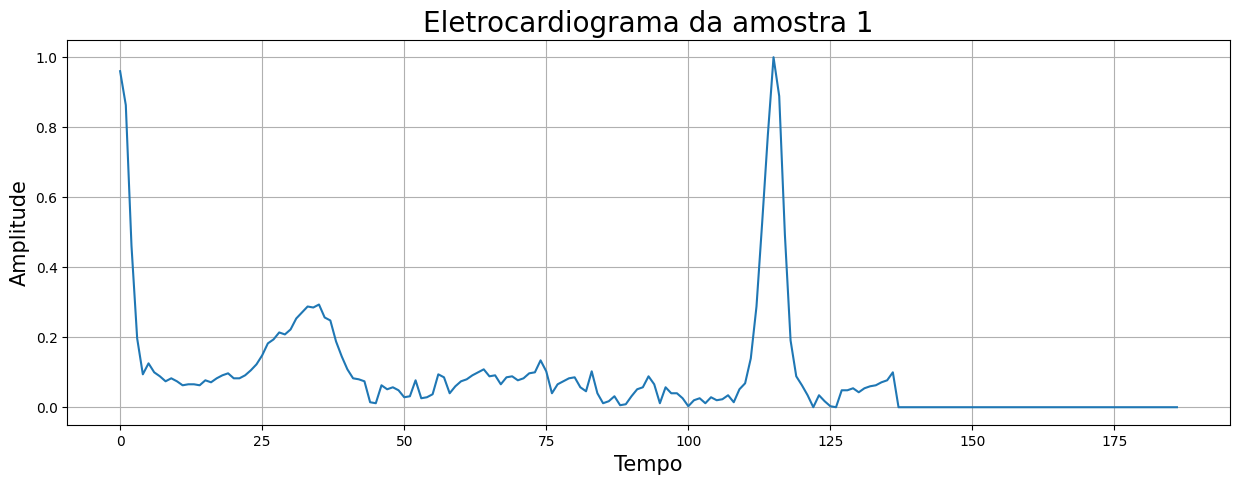

[0. 1. 2. 3. 4.]


In [5]:
index = 1
ecg_sample = X_train[index]
print('Treino:', len(X_train))
print("Teste: ", len(X_test))
print('Total:', len(X_train) + len(X_test))

plt.figure(figsize=(15, 5))
plt.plot(ecg_sample)
plt.title(f'Eletrocardiograma da amostra {index}', fontsize=20)
plt.xlabel('Tempo', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.grid(True)
plt.show()
print(np.unique(y_train))

In [6]:
print(f"Treino: {mitbih_train.shape}")
print(f"Test: {mitbih_test.shape}")
print("-----------------")
print(f"Treino (X):", {X_train.shape})
print(f"Treino (y):", {y_train.shape})
print(f"Teste (X):", {X_test.shape})
print(f"Teste (y):", {y_test.shape})
print(f"Validação (X):", {X_val.shape})
print(f"Validação (y):", {y_val.shape})

Treino: (87554, 188)
Test: (21892, 188)
-----------------
Treino (X): {(87554, 187)}
Treino (y): {(87554,)}
Teste (X): {(10946, 187)}
Teste (y): {(10946,)}
Validação (X): {(10946, 187)}
Validação (y): {(10946,)}


# Valores padrões

In [23]:
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)  # Usando o XGBoost com parâmetros padrão
xgb_clf.fit(X_train, y_train)

y_val_pred = xgb_clf.predict(X_val)
classification_report_val = classification_report(y_val, y_val_pred, output_dict=True)

y_test_pred = xgb_clf.predict(X_test)
classification_report_test = classification_report(y_test, y_test_pred, output_dict=True)

print("Relatório de Classificação - Validação (XGBoost)")
print(classification_report(y_val, y_val_pred))

print("Relatório de Classificação - Teste (XGBoost)")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
specificities_test = []
for i in range(len(cm_test)):
    TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
    FP = np.sum(cm_test[:, i]) - cm_test[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_test.append(specificity)

specificity_mean_test = np.mean(specificities_test)
print(f"Especificidade Média do XGBoost (Teste): {specificity_mean_test:.4f}")

cm_val = confusion_matrix(y_val, y_val_pred)
specificities_val = []
for i in range(len(cm_val)):
    TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
    FP = np.sum(cm_val[:, i]) - cm_val[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_val.append(specificity)

specificity_mean_val = np.mean(specificities_val)
print(f"Especificidade Média do XGBoost (Validação): {specificity_mean_val:.4f}")


Relatório de Classificação - Validação (XGBoost)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9106
         1.0       0.94      0.71      0.81       267
         2.0       0.97      0.92      0.94       694
         3.0       0.85      0.65      0.74        84
         4.0       0.99      0.97      0.98       795

    accuracy                           0.98     10946
   macro avg       0.95      0.85      0.89     10946
weighted avg       0.98      0.98      0.98     10946

Relatório de Classificação - Teste (XGBoost)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9012
         1.0       0.94      0.66      0.77       289
         2.0       0.98      0.93      0.95       754
         3.0       0.91      0.78      0.84        78
         4.0       0.99      0.98      0.98       813

    accuracy                           0.98     10946
   macro avg       0.96      0.87    

# n_estimators [1-100]

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

specificity_means_test = []
specificity_means_val = []

best_n_estimators = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

for n in range(1, 1001):
    xgb_clf = xgb.XGBClassifier(n_estimators=n, eval_metric='mlogloss')
    xgb_clf.fit(X_train_scaled, y_train)

    y_val_pred = xgb_clf.predict(X_val_scaled)

    y_test_pred = xgb_clf.predict(X_test_scaled)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)
    specificity_means_test.append(specificity_mean_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)
    specificity_means_val.append(specificity_mean_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_n_estimators = n
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de n_estimators encontrado: {best_n_estimators}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")


Melhor valor de n_estimators encontrado: 944

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9012
         1.0       0.96      0.70      0.81       289
         2.0       0.98      0.94      0.96       754
         3.0       0.90      0.81      0.85        78
         4.0       1.00      0.98      0.99       813

    accuracy                           0.98     10946
   macro avg       0.96      0.89      0.92     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9106
         1.0       0.96      0.72      0.82       267
         2.0       0.97      0.93      0.95       694
         3.0       0.86      0.70      0.77        84
         4.0       0.99      0.97      0.98       795

    accuracy                    

# learning_rate

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

specificity_means_test = []
specificity_means_val = []

best_learning_rate = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

# Testando diferentes valores de learning_rate
for lr in learning_rates:
    xgb_clf = xgb.XGBClassifier(learning_rate=lr, n_estimators=994, random_state=42, eval_metric='mlogloss')
    xgb_clf.fit(X_train_scaled, y_train)

    y_val_pred = xgb_clf.predict(X_val_scaled)

    y_test_pred = xgb_clf.predict(X_test_scaled)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)
    specificity_means_test.append(specificity_mean_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)
    specificity_means_val.append(specificity_mean_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_learning_rate = lr
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de learning_rate encontrado: {best_learning_rate}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")


Melhor valor de learning_rate encontrado: 0.5

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9012
         1.0       0.96      0.70      0.81       289
         2.0       0.98      0.94      0.96       754
         3.0       0.90      0.82      0.86        78
         4.0       1.00      0.98      0.99       813

    accuracy                           0.98     10946
   macro avg       0.96      0.89      0.92     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9106
         1.0       0.94      0.73      0.83       267
         2.0       0.97      0.93      0.95       694
         3.0       0.85      0.71      0.77        84
         4.0       0.99      0.97      0.98       795

    accuracy                   

# max_depth

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

specificity_means_test = []
specificity_means_val = []

best_max_depth = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for md in max_depth_values:
    xgb_clf = xgb.XGBClassifier(max_depth=md, n_estimators=994, learning_rate=0.5, random_state=42, eval_metric='mlogloss')
    xgb_clf.fit(X_train_scaled, y_train)

    y_val_pred = xgb_clf.predict(X_val_scaled)

    y_test_pred = xgb_clf.predict(X_test_scaled)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)
    specificity_means_test.append(specificity_mean_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)
    specificity_means_val.append(specificity_mean_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_max_depth = md
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de max_depth encontrado: {best_max_depth}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")


Melhor valor de max_depth encontrado: 6

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9012
         1.0       0.96      0.70      0.81       289
         2.0       0.98      0.94      0.96       754
         3.0       0.90      0.82      0.86        78
         4.0       1.00      0.98      0.99       813

    accuracy                           0.98     10946
   macro avg       0.96      0.89      0.92     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9106
         1.0       0.94      0.73      0.83       267
         2.0       0.97      0.93      0.95       694
         3.0       0.85      0.71      0.77        84
         4.0       0.99      0.97      0.98       795

    accuracy                         

# min_child_weight

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

specificity_means_test = []
specificity_means_val = []

best_min_child_weight = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

min_child_weight_values = [1, 3, 5, 7, 10]

for mcw in min_child_weight_values:
    xgb_clf = xgb.XGBClassifier(min_child_weight=mcw, n_estimators=994, learning_rate=0.5, max_depth=6, random_state=42, eval_metric='mlogloss')
    xgb_clf.fit(X_train_scaled, y_train)

    y_val_pred = xgb_clf.predict(X_val_scaled)

    y_test_pred = xgb_clf.predict(X_test_scaled)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)
    specificity_means_test.append(specificity_mean_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)
    specificity_means_val.append(specificity_mean_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_min_child_weight = mcw
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de min_child_weight encontrado: {best_min_child_weight}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")


Melhor valor de min_child_weight encontrado: 5

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9012
         1.0       0.96      0.70      0.81       289
         2.0       0.98      0.94      0.96       754
         3.0       0.89      0.82      0.85        78
         4.0       1.00      0.99      0.99       813

    accuracy                           0.98     10946
   macro avg       0.96      0.89      0.92     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9106
         1.0       0.96      0.74      0.83       267
         2.0       0.97      0.94      0.95       694
         3.0       0.86      0.74      0.79        84
         4.0       0.99      0.97      0.98       795

    accuracy                  

# Subsample

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

specificity_means_test = []
specificity_means_val = []

best_subsample = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

subsample_values = [0.6, 0.7, 0.8, 0.9, 1.0]

for subs in subsample_values:
    xgb_clf = xgb.XGBClassifier(subsample=subs, n_estimators=994, learning_rate=0.5, max_depth=6, min_child_weight=5, random_state=42, eval_metric='mlogloss')
    xgb_clf.fit(X_train_scaled, y_train)

    y_val_pred = xgb_clf.predict(X_val_scaled)

    y_test_pred = xgb_clf.predict(X_test_scaled)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)
    specificity_means_test.append(specificity_mean_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)
    specificity_means_val.append(specificity_mean_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_subsample = subs
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de subsample encontrado: {best_subsample}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")


Melhor valor de subsample encontrado: 1.0

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9012
         1.0       0.96      0.70      0.81       289
         2.0       0.98      0.94      0.96       754
         3.0       0.89      0.82      0.85        78
         4.0       1.00      0.99      0.99       813

    accuracy                           0.98     10946
   macro avg       0.96      0.89      0.92     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9106
         1.0       0.96      0.74      0.83       267
         2.0       0.97      0.94      0.95       694
         3.0       0.86      0.74      0.79        84
         4.0       0.99      0.97      0.98       795

    accuracy                       

# colsample_bytree

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

specificity_means_test = []
specificity_means_val = []

best_colsample_bytree = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

colsample_bytree_values = [0.3, 0.5, 0.7, 0.9, 1.0]

for csbt in colsample_bytree_values:
    xgb_clf = xgb.XGBClassifier(colsample_bytree=csbt, n_estimators=994, learning_rate=0.5, max_depth=6, min_child_weight=5, subsample=1, random_state=42, eval_metric='mlogloss')
    xgb_clf.fit(X_train_scaled, y_train)

    y_val_pred = xgb_clf.predict(X_val_scaled)

    y_test_pred = xgb_clf.predict(X_test_scaled)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)
    specificity_means_test.append(specificity_mean_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)
    specificity_means_val.append(specificity_mean_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_colsample_bytree = csbt
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de colsample_bytree encontrado: {best_colsample_bytree}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")


Melhor valor de colsample_bytree encontrado: 1.0

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9012
         1.0       0.96      0.70      0.81       289
         2.0       0.98      0.94      0.96       754
         3.0       0.89      0.82      0.85        78
         4.0       1.00      0.99      0.99       813

    accuracy                           0.98     10946
   macro avg       0.96      0.89      0.92     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9106
         1.0       0.96      0.74      0.83       267
         2.0       0.97      0.94      0.95       694
         3.0       0.86      0.74      0.79        84
         4.0       0.99      0.97      0.98       795

    accuracy                

# Gamma

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

specificity_means_test = []
specificity_means_val = []

best_gamma = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

gamma_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

for gamma in gamma_values:
    xgb_clf = xgb.XGBClassifier(gamma=gamma, n_estimators=994, learning_rate=0.5, max_depth=6, min_child_weight=5, subsample=1, colsample_bytree= 1, random_state=42, eval_metric='mlogloss')
    xgb_clf.fit(X_train_scaled, y_train)

    y_val_pred = xgb_clf.predict(X_val_scaled)

    y_test_pred = xgb_clf.predict(X_test_scaled)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)
    specificity_means_test.append(specificity_mean_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)
    specificity_means_val.append(specificity_mean_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_gamma = gamma
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de gamma encontrado: {best_gamma}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")


Melhor valor de gamma encontrado: 0

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9012
         1.0       0.96      0.70      0.81       289
         2.0       0.98      0.94      0.96       754
         3.0       0.89      0.82      0.85        78
         4.0       1.00      0.99      0.99       813

    accuracy                           0.98     10946
   macro avg       0.96      0.89      0.92     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9106
         1.0       0.96      0.74      0.83       267
         2.0       0.97      0.94      0.95       694
         3.0       0.86      0.74      0.79        84
         4.0       0.99      0.97      0.98       795

    accuracy                           0.

# Final

## Default

In [24]:
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)  # Usando o XGBoost com parâmetros padrão
xgb_clf.fit(X_train, y_train)

y_val_pred = xgb_clf.predict(X_val)
classification_report_val = classification_report(y_val, y_val_pred, output_dict=True)

y_test_pred = xgb_clf.predict(X_test)
classification_report_test = classification_report(y_test, y_test_pred, output_dict=True)

print("Relatório de Classificação - Validação (XGBoost)")
print(classification_report(y_val, y_val_pred))

print("Relatório de Classificação - Teste (XGBoost)")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
specificities_test = []
for i in range(len(cm_test)):
    TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
    FP = np.sum(cm_test[:, i]) - cm_test[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_test.append(specificity)

specificity_mean_test = np.mean(specificities_test)
print(f"Especificidade Média do XGBoost (Teste): {specificity_mean_test:.4f}")

cm_val = confusion_matrix(y_val, y_val_pred)
specificities_val = []
for i in range(len(cm_val)):
    TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
    FP = np.sum(cm_val[:, i]) - cm_val[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_val.append(specificity)

specificity_mean_val = np.mean(specificities_val)
print(f"Especificidade Média do XGBoost (Validação): {specificity_mean_val:.4f}")


Relatório de Classificação - Validação (XGBoost)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9106
         1.0       0.94      0.71      0.81       267
         2.0       0.97      0.92      0.94       694
         3.0       0.85      0.65      0.74        84
         4.0       0.99      0.97      0.98       795

    accuracy                           0.98     10946
   macro avg       0.95      0.85      0.89     10946
weighted avg       0.98      0.98      0.98     10946

Relatório de Classificação - Teste (XGBoost)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9012
         1.0       0.94      0.66      0.77       289
         2.0       0.98      0.93      0.95       754
         3.0       0.91      0.78      0.84        78
         4.0       0.99      0.98      0.98       813

    accuracy                           0.98     10946
   macro avg       0.96      0.87    

## Otimizado

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

specificity_means_test = []
specificity_means_val = []

best_gamma = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

gamma_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

for gamma in gamma_values:
    xgb_clf = xgb.XGBClassifier(gamma=gamma, n_estimators=994, learning_rate=0.5, max_depth=6, min_child_weight=5, subsample=1, colsample_bytree= 1, random_state=42, eval_metric='mlogloss')
    xgb_clf.fit(X_train_scaled, y_train)

    y_val_pred = xgb_clf.predict(X_val_scaled)

    y_test_pred = xgb_clf.predict(X_test_scaled)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)
    specificity_means_test.append(specificity_mean_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)
    specificity_means_val.append(specificity_mean_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_gamma = gamma
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de gamma encontrado: {best_gamma}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")


Melhor valor de gamma encontrado: 0

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9012
         1.0       0.96      0.70      0.81       289
         2.0       0.98      0.94      0.96       754
         3.0       0.89      0.82      0.85        78
         4.0       1.00      0.99      0.99       813

    accuracy                           0.98     10946
   macro avg       0.96      0.89      0.92     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9106
         1.0       0.96      0.74      0.83       267
         2.0       0.97      0.94      0.95       694
         3.0       0.86      0.74      0.79        84
         4.0       0.99      0.97      0.98       795

    accuracy                           0.